# Data transformation to save for frontend visualizations

In [47]:
# !pip install matplotlib

In [27]:
import pandas as pd

# grouped by NAID and sorted by title
df=pd.read_parquet('../df_grouped_NAID_sorted_title_categories.parquet')

In [28]:
import sys
import os
sys.path.append('..')
from set_categories import category_dict

#### Count per application category

In [ ]:
# the categories we care about plotting
categories = [key for key in category_dict.keys() if key != "nara archival administrative sheets"] + ['unknown']

# all possible categories in file_cat columns
all_categories = list(category_dict.keys()) + ['unknown', 'non_application'] 

categories 

['soldier',
 'rejected',
 'widow',
 'bounty land warrant',
 'old war',
 'N A Acc',
 'unknown']

In [30]:
# get count of applications per category (some applications have multiple categories and will be counted for each)

# count dictionary where categories is the key and the starting value is 0
count_dict = {cat: {'count': 0, 'NAIDs': ''} for cat in all_categories}
# print(count_dict)

# iterate through df and add 1 to the count for the category
for index, row in df.iterrows():
    cats = row['file_cat'].split('||')
    for cat in cats:
        count_dict[cat]['count'] += 1
        count_dict[cat]['NAIDs'] += (row['NAID'] + '||')

print(count_dict)

# print just the counts of the count_dict
for cat in all_categories:
    print(cat, count_dict[cat]['count'])


{'soldier': {'count': 37038, 'NAIDs': '144291425||54508399||111491126||54219959||53952545||54643912||54330550||53840823||53997113||54952318||54850948||54774692||54035305||54838621||111701469||111702514||53852270||53852272||54714436||54787488||54573391||54417693||53997118||54952311||54638057||111510499||196483979||54550655||196682341||196317522||54364341||196682313||54619420||196669260||54526203||54095241||111775858||54952320||111693988||111730426||111504234||111670540||111504238||111670544||111504236||111670542||111500404||111638290||54125978||54631036||53936879||54083881||54140921||54348482||54411265||111442571||54417691||54380789||54457362||54457401||111441198||54546420||111713523||54611760||54787500||54577086||54554286||54609043||54555542||54630548||111533755||54669437||111689194||54699070||54743313||54729473||53903502||54895070||54828785||53895983||144249935||54294318||53921918||54591281||54805910||54304420||196374439||54793849||196628620||144231043||54442747||196667919||54503374||

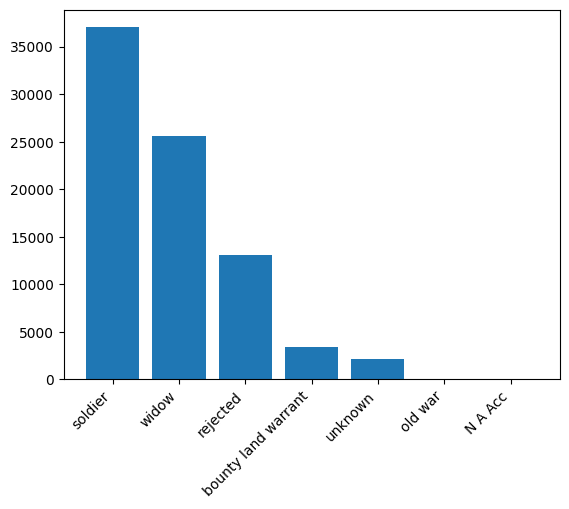

In [31]:
# use matplotlib to plot the counts of the count_dict sorted by count
import matplotlib.pyplot as plt

sorted_counts = sorted(count_dict.items(), key=lambda x: x[1]['count'], reverse=True)

# exclude non_application from sorted_counts
sorted_counts = [x for x in sorted_counts if x[0] != 'non_application' and x[0] != 'nara archival administrative sheets']

# arrange the bars in descending order and orient the labels at 45 degrees
plt.bar([x[0] for x in sorted_counts], [x[1]['count'] for x in sorted_counts])
plt.xticks(rotation=45, ha='right')
plt.show()


#### Avg num pages per application category

In [32]:
# original data
df_original=pd.read_parquet('../nara_pension_file_pages.parquet')

In [33]:
# check if pageObjectId is ever empty or null or '' in the original data
print(df_original['pageObjectId'].isnull().any())
print(df_original['pageObjectId'].isna().any())
print(df_original['pageObjectId'].eq('').any())
print(df_original['pageObjectId'].eq(' ').any())

False
False
False
False


In [36]:
# count the number of pageObjectId entries for each naid which are separated by '||'
# add 'page_count' to count_dict
for cat in all_categories:
    count_dict[cat]['page_count'] = ''

# for each row in df that includes the cat then count the pageObjectId entries for each naid which are separated by '||'
# add the page_count to the count_dict
for index, row in df.iterrows():
    pages = len(row['pageObjectId'].split('||'))
    file_cat = row['file_cat']
    
    # Handle multiple categories separated by ||
    if '||' in file_cat:
        cats_in_row = file_cat.split('||')
    else:
        cats_in_row = [file_cat] if file_cat else []
    
    for cat in cats_in_row:
        if cat in count_dict:
            count_dict[cat]['page_count'] += (str(pages) + '||')

# calculate average page count for each category
for cat in all_categories:
    if count_dict[cat]['page_count']:
        # Split the string by ||, convert to int, and calculate average
        page_counts = [int(x) for x in count_dict[cat]['page_count'].rstrip('||').split('||') if x]
        count_dict[cat]['avg_page_count'] = sum(page_counts) / len(page_counts) if page_counts else 0
    else:
        count_dict[cat]['avg_page_count'] = 0

# print the count_dict keys for count and avg_page_count
for cat in all_categories:
    print(cat, count_dict[cat]['count'], count_dict[cat]['avg_page_count'])



soldier 37038 21.90193854959771
rejected 13124 24.568652849740932
widow 25629 39.97608178235593
bounty land warrant 3373 8.805217906907798
old war 64 27.015625
N A Acc 13 1.0
nara archival administrative sheets 303 51.102310231023104
unknown 2179 38.64983937586049
non_application 322 58.04347826086956


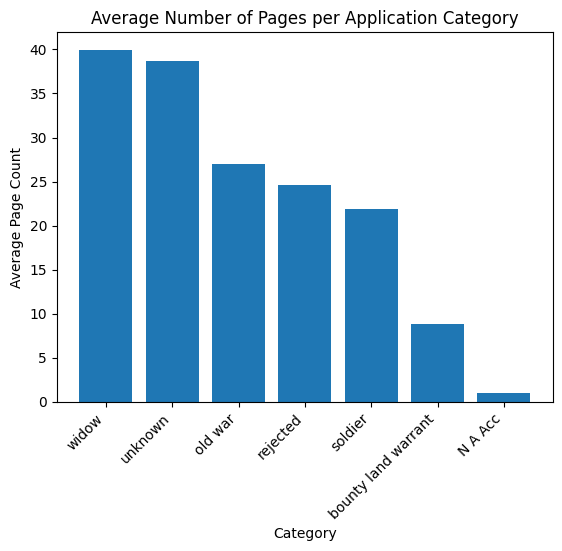

In [35]:
# use matplotlib to plot the average page counts of the count_dict sorted by avg_page_count
import matplotlib.pyplot as plt

sorted_avg_pages = sorted(count_dict.items(), key=lambda x: x[1]['avg_page_count'], reverse=True)

# exclude non_application from sorted_avg_pages
sorted_avg_pages = [x for x in sorted_avg_pages if x[0] != 'non_application' and x[0] != 'nara archival administrative sheets']

# arrange the bars in descending order and orient the labels at 45 degrees
plt.bar([x[0] for x in sorted_avg_pages], [x[1]['avg_page_count'] for x in sorted_avg_pages])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Average Page Count')
plt.title('Average Number of Pages per Application Category')
plt.show()


In [49]:
# Export count_dict to JSON
import json

with open('category_count_dict.json', 'w') as f:
    json.dump(count_dict, f, indent=2)

print("Category count dictionary exported to 'count_dict.json'")
print("This includes:")
print("- count: number of applications per category")
print("- NAIDs: string of NAIDs separated by '||'")
print("- page_count: string of page counts separated by '||'")
print("- avg_page_count: average pages per category")


Category count dictionary exported to 'count_dict.json'
This includes:
- count: number of applications per category
- NAIDs: string of NAIDs separated by '||'
- page_count: string of page counts separated by '||'
- avg_page_count: average pages per category


### Below this point is code mainly from copilot in response to prompts related to analyzing category overlaps

In [39]:
# Analyze category combinations and pairings
from collections import Counter
import itertools

# Get all unique category combinations
category_combinations = []
single_categories = []

for index, row in df.iterrows():
    file_cat = row['file_cat']
    if file_cat and file_cat != 'non_application':
        # Split categories by ||
        cats = [cat.strip() for cat in file_cat.split('||') if cat.strip()]
        
        # Filter to only include categories we care about
        filtered_cats = [cat for cat in cats if cat in categories]
        
        if len(filtered_cats) == 1:
            single_categories.append(filtered_cats[0])
        elif len(filtered_cats) > 1:
            # Sort to ensure consistent ordering
            sorted_cats = sorted(filtered_cats)
            category_combinations.append('||'.join(sorted_cats))

# Count single categories
single_counts = Counter(single_categories)

# Count combinations
combo_counts = Counter(category_combinations)

print("Single Categories:")
for cat, count in single_counts.most_common():
    print(f"  {cat}: {count}")

print("\nCategory Combinations:")
for combo, count in combo_counts.most_common(10):  # Top 10 combinations
    print(f"  {combo}: {count}")

print(f"\nTotal single categories: {sum(single_counts.values())}")
print(f"Total combinations: {sum(combo_counts.values())}")
print(f"Total applications analyzed: {sum(single_counts.values()) + sum(combo_counts.values())}")


Single Categories:
  soldier: 34957
  widow: 24252
  rejected: 10745
  bounty land warrant: 3060
  unknown: 2179
  old war: 17
  N A Acc: 9

Category Combinations:
  rejected||soldier: 1411
  rejected||widow: 830
  soldier||widow: 475
  bounty land warrant||soldier: 166
  bounty land warrant||rejected: 105
  bounty land warrant||widow: 34
  old war||widow: 12
  old war||rejected||widow: 12
  old war||soldier: 7
  old war||rejected: 5

Total single categories: 75219
Total combinations: 3082
Total applications analyzed: 78301


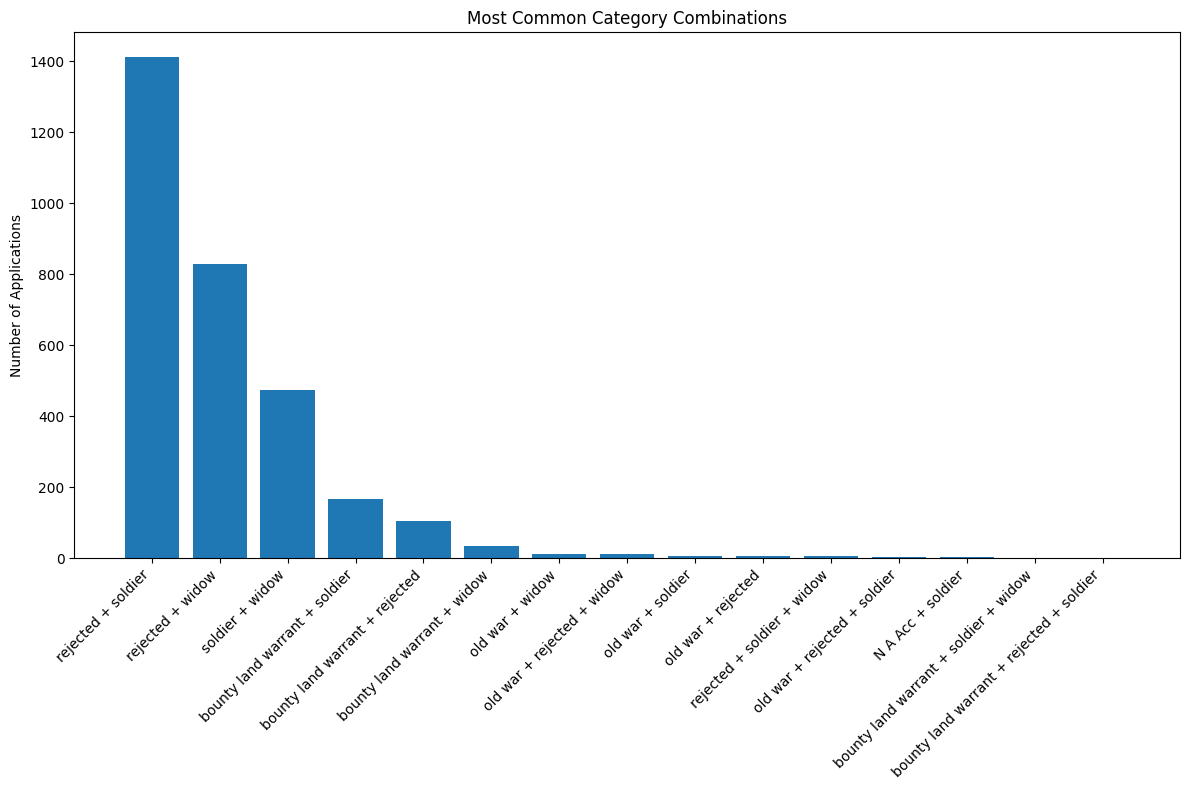


Top Category Combinations:
 1. rejected + soldier: 1411
 2. rejected + widow: 830
 3. soldier + widow: 475
 4. bounty land warrant + soldier: 166
 5. bounty land warrant + rejected: 105
 6. bounty land warrant + widow: 34
 7. old war + widow: 12
 8. old war + rejected + widow: 12
 9. old war + soldier: 7
10. old war + rejected: 5
11. rejected + soldier + widow: 5
12. old war + rejected + soldier: 4
13. N A Acc + soldier: 3
14. bounty land warrant + soldier + widow: 2
15. bounty land warrant + rejected + soldier: 2


In [40]:
# Visualize category combinations
import matplotlib.pyplot as plt

# Get top combinations for visualization
top_combos = combo_counts.most_common(15)

if top_combos:
    combo_names = [combo.replace('||', ' + ') for combo, count in top_combos]
    combo_counts_list = [count for combo, count in top_combos]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(combo_names)), combo_counts_list)
    plt.xticks(range(len(combo_names)), combo_names, rotation=45, ha='right')
    plt.ylabel('Number of Applications')
    plt.title('Most Common Category Combinations')
    plt.tight_layout()
    plt.show()
    
    # Also show as a simple text summary
    print("\nTop Category Combinations:")
    for i, (combo, count) in enumerate(top_combos, 1):
        print(f"{i:2d}. {combo.replace('||', ' + ')}: {count}")
else:
    print("No category combinations found.")


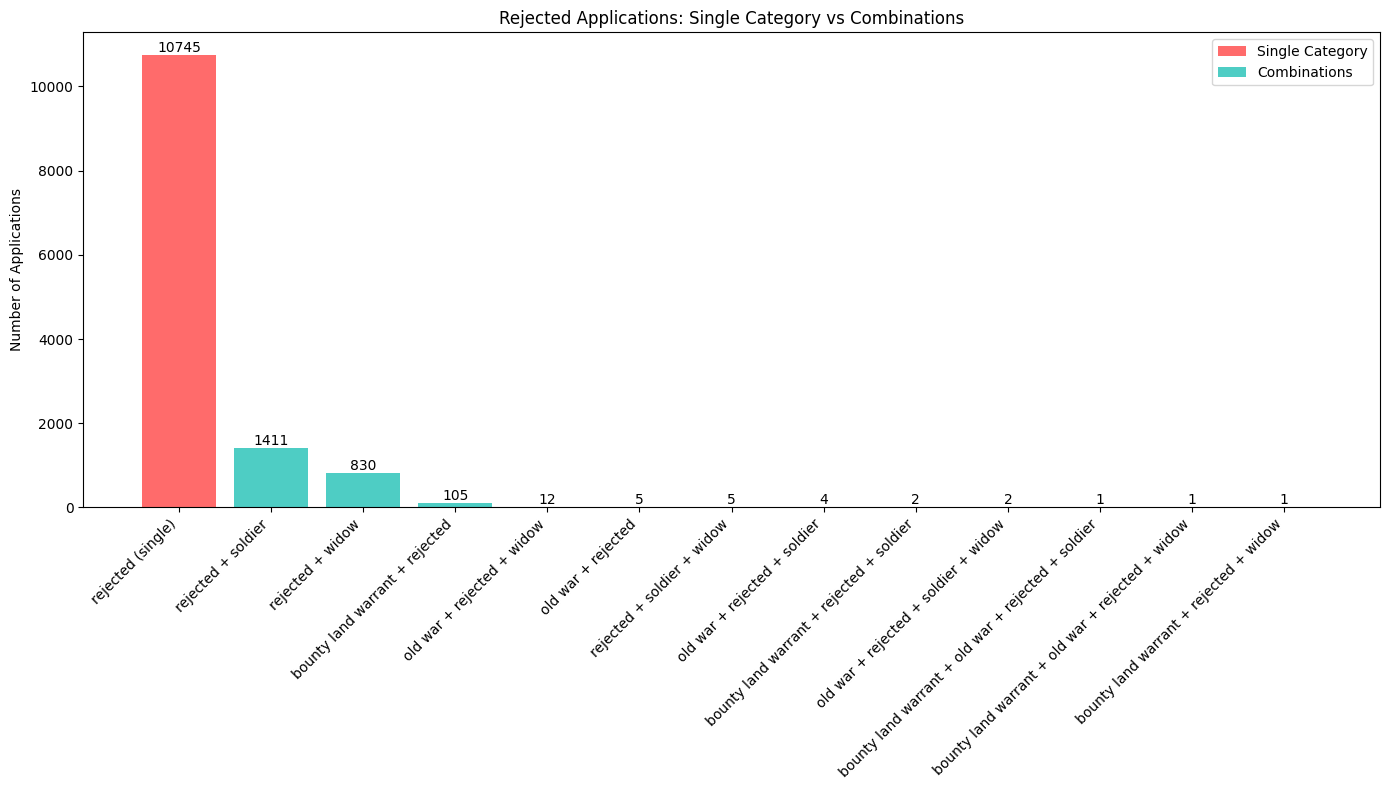

Rejected Applications Breakdown:
Total rejected applications: 13124
Single 'rejected' category: 10745 (81.9%)
In combinations: 2379 (18.1%)

Detailed breakdown:
  rejected (single): 10745
  rejected + soldier: 1411
  rejected + widow: 830
  bounty land warrant + rejected: 105
  old war + rejected + widow: 12
  old war + rejected: 5
  rejected + soldier + widow: 5
  old war + rejected + soldier: 4
  bounty land warrant + rejected + soldier: 2
  old war + rejected + soldier + widow: 2
  bounty land warrant + old war + rejected + soldier: 1
  bounty land warrant + old war + rejected + widow: 1
  bounty land warrant + rejected + widow: 1


In [41]:
# Focus on "rejected" category - single and combinations
import matplotlib.pyplot as plt

# Get all rejected-related categories and combinations
rejected_data = {}

# Single "rejected" category
if 'rejected' in single_counts:
    rejected_data['rejected (single)'] = single_counts['rejected']

# All combinations that include "rejected"
for combo, count in combo_counts.items():
    if 'rejected' in combo:
        # Replace || with + for better readability
        display_name = combo.replace('||', ' + ')
        rejected_data[display_name] = count

# Sort by count (descending)
sorted_rejected = sorted(rejected_data.items(), key=lambda x: x[1], reverse=True)

if sorted_rejected:
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    combo_names = [name for name, count in sorted_rejected]
    combo_counts_list = [count for name, count in sorted_rejected]
    
    # Create bars with different colors for single vs combinations
    colors = ['#ff6b6b' if 'single' in name else '#4ecdc4' for name in combo_names]
    
    bars = plt.bar(range(len(combo_names)), combo_counts_list, color=colors)
    
    # Customize the plot
    plt.xticks(range(len(combo_names)), combo_names, rotation=45, ha='right')
    plt.ylabel('Number of Applications')
    plt.title('Rejected Applications: Single Category vs Combinations')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#ff6b6b', label='Single Category'),
                      Patch(facecolor='#4ecdc4', label='Combinations')]
    plt.legend(handles=legend_elements)
    
    # Add value labels on bars
    for bar, count in zip(bars, combo_counts_list):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Rejected Applications Breakdown:")
    print("=" * 40)
    total_rejected = sum(combo_counts_list)
    single_rejected = rejected_data.get('rejected (single)', 0)
    combination_rejected = total_rejected - single_rejected
    
    print(f"Total rejected applications: {total_rejected}")
    print(f"Single 'rejected' category: {single_rejected} ({single_rejected/total_rejected*100:.1f}%)")
    print(f"In combinations: {combination_rejected} ({combination_rejected/total_rejected*100:.1f}%)")
    print("\nDetailed breakdown:")
    for name, count in sorted_rejected:
        print(f"  {name}: {count}")
        
else:
    print("No rejected applications found.")


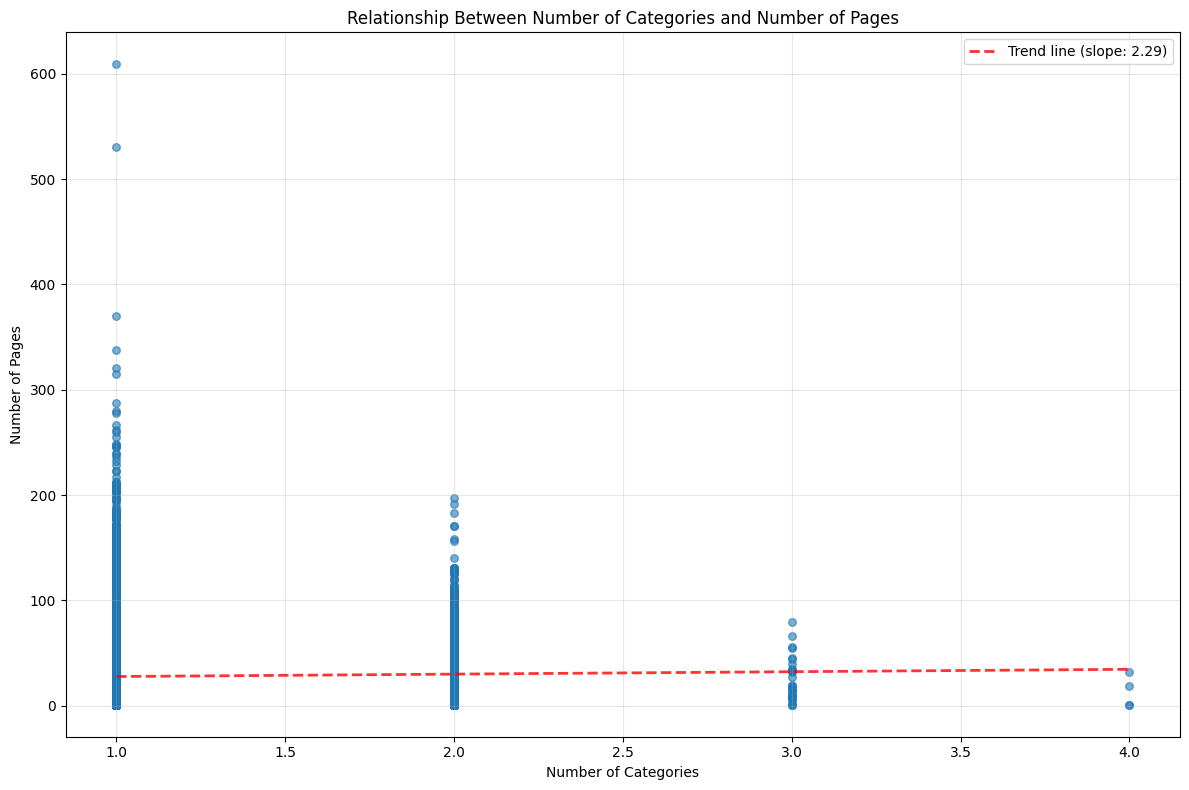

Correlation coefficient: 0.019

Average pages by number of categories:
1 category(ies): 27.7 ± 23.6 pages (n=75219)
2 category(ies): 30.3 ± 25.2 pages (n=3049)
3 category(ies): 24.7 ± 20.6 pages (n=29)
4 category(ies): 13.2 ± 13.1 pages (n=4)


In [45]:
# Analyze relationship between number of categories and number of pages
import matplotlib.pyplot as plt
import numpy as np

# Create data for analysis
category_count_data = []
page_count_data = []

for index, row in df.iterrows():
    file_cat = row['file_cat']
    if file_cat and file_cat != 'non_application':
        # Count categories
        cats = [cat.strip() for cat in file_cat.split('||') if cat.strip()]
        filtered_cats = [cat for cat in cats if cat in categories]
        num_categories = len(filtered_cats)
        
        # Only include applications with at least 1 category
        if num_categories > 0:
            # Count pages
            num_pages = len(row['pageObjectId'].split('||'))
            
            category_count_data.append(num_categories)
            page_count_data.append(num_pages)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(category_count_data, page_count_data, alpha=0.6, s=30)
plt.xlabel('Number of Categories')
plt.ylabel('Number of Pages')
plt.title('Relationship Between Number of Categories and Number of Pages')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(category_count_data, page_count_data, 1)
p = np.poly1d(z)
plt.plot(sorted(set(category_count_data)), p(sorted(set(category_count_data))), "r--", alpha=0.8, linewidth=2, label=f'Trend line (slope: {z[0]:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(category_count_data, page_count_data)[0, 1]
print(f"Correlation coefficient: {correlation:.3f}")

# Analyze by category count
from collections import defaultdict
category_groups = defaultdict(list)

for i, (cat_count, page_count) in enumerate(zip(category_count_data, page_count_data)):
    category_groups[cat_count].append(page_count)

print("\nAverage pages by number of categories:")
print("=" * 40)
for cat_count in sorted(category_groups.keys()):
    pages = category_groups[cat_count]
    avg_pages = np.mean(pages)
    std_pages = np.std(pages)
    count = len(pages)
    print(f"{cat_count} category(ies): {avg_pages:.1f} ± {std_pages:.1f} pages (n={count})")


In [46]:
# Compile comprehensive analysis into a dictionary/JSON
import json
from collections import Counter

# Calculate category distribution
total_applications = len(df[df['file_cat'] != 'non_application'])
single_category_count = sum(single_counts.values())
multi_category_count = sum(combo_counts.values())

# Calculate percentages
single_percentage = (single_category_count / total_applications) * 100
multi_percentage = (multi_category_count / total_applications) * 100

# Category count distribution
category_count_distribution = {}
for cat_count in sorted(category_groups.keys()):
    count = len(category_groups[cat_count])
    percentage = (count / total_applications) * 100
    avg_pages = np.mean(category_groups[cat_count])
    std_pages = np.std(category_groups[cat_count])
    
    category_count_distribution[cat_count] = {
        'count': count,
        'percentage': round(percentage, 2),
        'avg_pages': round(avg_pages, 1),
        'std_pages': round(std_pages, 1)
    }

# Top category combinations
top_combinations = []
for combo, count in combo_counts.most_common(20):
    percentage = (count / total_applications) * 100
    top_combinations.append({
        'combination': combo.replace('||', ' + '),
        'count': count,
        'percentage': round(percentage, 2)
    })

# Top single categories
top_single_categories = []
for cat, count in single_counts.most_common():
    percentage = (count / total_applications) * 100
    top_single_categories.append({
        'category': cat,
        'count': count,
        'percentage': round(percentage, 2)
    })

# Compile comprehensive analysis
analysis_summary = {
    'overview': {
        'total_applications_analyzed': total_applications,
        'single_category_applications': {
            'count': single_category_count,
            'percentage': round(single_percentage, 2)
        },
        'multi_category_applications': {
            'count': multi_category_count,
            'percentage': round(multi_percentage, 2)
        }
    },
    'category_count_distribution': category_count_distribution,
    'correlation_analysis': {
        'correlation_coefficient': round(correlation, 3),
        'interpretation': 'Very weak positive correlation - almost no relationship between number of categories and page count'
    },
    'top_single_categories': top_single_categories,
    'top_category_combinations': top_combinations,
    'page_count_analysis': {
        'by_category_count': category_count_distribution
    }
}

# Print summary
print("=== COMPREHENSIVE CATEGORY ANALYSIS ===")
print(f"Total applications analyzed: {total_applications:,}")
print(f"Single category: {single_category_count:,} ({single_percentage:.1f}%)")
print(f"Multiple categories: {multi_category_count:,} ({multi_percentage:.1f}%)")
print(f"Correlation (categories vs pages): {correlation:.3f}")

print("\n=== CATEGORY COUNT DISTRIBUTION ===")
for cat_count, data in category_count_distribution.items():
    print(f"{cat_count} category(ies): {data['count']:,} ({data['percentage']:.1f}%) - {data['avg_pages']:.1f} ± {data['std_pages']:.1f} pages")

print("\n=== TOP 10 SINGLE CATEGORIES ===")
for i, cat in enumerate(top_single_categories[:10], 1):
    print(f"{i:2d}. {cat['category']}: {cat['count']:,} ({cat['percentage']:.1f}%)")

print("\n=== TOP 10 CATEGORY COMBINATIONS ===")
for i, combo in enumerate(top_combinations[:10], 1):
    print(f"{i:2d}. {combo['combination']}: {combo['count']:,} ({combo['percentage']:.1f}%)")

# Save to JSON file
with open('category_analysis_summary.json', 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print(f"\n=== ANALYSIS SAVED ===")
print("Complete analysis saved to 'category_analysis_summary.json'")
print("Dictionary also available as 'analysis_summary' variable")


=== COMPREHENSIVE CATEGORY ANALYSIS ===
Total applications analyzed: 78,604
Single category: 75,219 (95.7%)
Multiple categories: 3,082 (3.9%)
Correlation (categories vs pages): 0.019

=== CATEGORY COUNT DISTRIBUTION ===
1 category(ies): 75,219 (95.7%) - 27.7 ± 23.6 pages
2 category(ies): 3,049 (3.9%) - 30.3 ± 25.2 pages
3 category(ies): 29 (0.0%) - 24.7 ± 20.6 pages
4 category(ies): 4 (0.0%) - 13.2 ± 13.1 pages

=== TOP 10 SINGLE CATEGORIES ===
 1. soldier: 34,957 (44.5%)
 2. widow: 24,252 (30.9%)
 3. rejected: 10,745 (13.7%)
 4. bounty land warrant: 3,060 (3.9%)
 5. unknown: 2,179 (2.8%)
 6. old war: 17 (0.0%)
 7. N A Acc: 9 (0.0%)

=== TOP 10 CATEGORY COMBINATIONS ===
 1. rejected + soldier: 1,411 (1.8%)
 2. rejected + widow: 830 (1.1%)
 3. soldier + widow: 475 (0.6%)
 4. bounty land warrant + soldier: 166 (0.2%)
 5. bounty land warrant + rejected: 105 (0.1%)
 6. bounty land warrant + widow: 34 (0.0%)
 7. old war + widow: 12 (0.0%)
 8. old war + rejected + widow: 12 (0.0%)
 9. old wa